In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
binding_df = pd.read_csv(
    'BindingDB_All.tsv',
    sep='\t',
    on_bad_lines='skip',
    nrows=1000000)

/tmp/ipykernel_3516/3518116998.py:1: DtypeWarning: Columns (8,9,10,11,12,13,15,17,21,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,86,87,88,89,90,91,98,99,100,101,102,103,110,112,113,114,115,122,124,125,126,127,134,135,136,137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  binding_df = pd.read_csv(


In [3]:
for name in binding_df.columns:
    print(name)

BindingDB Reactant_set_id
Ligand SMILES
Ligand InChI
Ligand InChI Key
BindingDB MonomerID
BindingDB Ligand Name
Target Name
Target Source Organism According to Curator or DataSource
Ki (nM)
IC50 (nM)
Kd (nM)
EC50 (nM)
kon (M-1-s-1)
koff (s-1)
pH
Temp (C)
Curation/DataSource
Article DOI
BindingDB Entry DOI
PMID
PubChem AID
Patent Number
Authors
Institution
Link to Ligand in BindingDB
Link to Target in BindingDB
Link to Ligand-Target Pair in BindingDB
Ligand HET ID in PDB
PDB ID(s) for Ligand-Target Complex
PubChem CID
PubChem SID
ChEBI ID of Ligand
ChEMBL ID of Ligand
DrugBank ID of Ligand
IUPHAR_GRAC ID of Ligand
KEGG ID of Ligand
ZINC ID of Ligand
Number of Protein Chains in Target (>1 implies a multichain complex)
BindingDB Target Chain Sequence
PDB ID(s) of Target Chain
UniProt (SwissProt) Recommended Name of Target Chain
UniProt (SwissProt) Entry Name of Target Chain
UniProt (SwissProt) Primary ID of Target Chain
UniProt (SwissProt) Secondary ID(s) of Target Chain
UniProt (SwissPro

Drop duplicates

In [4]:
binding_df = binding_df.drop_duplicates() # equivalently binding_df.loc[~binding_df.duplicated()]
binding_df.shape

(999999, 194)

Find a unique identifier for target proteins

In [5]:
len(binding_df['BindingDB Target Chain Sequence'].value_counts())

4298

In [6]:
len(binding_df['PDB ID(s) of Target Chain'].value_counts())

2407

In [7]:
len(sorted(binding_df['Target Name'].value_counts().items()))

3578

### Exploration of covariates

Row name: ligand unique identifier (SMILES, InChi, BindingBD ID, etc.)

Candidate covariates (biological relevance): `Ki (nM)`, `IC50 (nM)`, `Kd (nM)`, `EC50 (nM)`, `kon (M-1-s-1)`, `koff (s-1)`, experimental conditions affecting measured affinities, i.e. `BindingDB Reactant_set_id`, `pH`, `temp` (`Target Source Organism [...]`?)

#### **Missing data**

In [10]:
print('There are {:.2f}% missing Ki values.\n'.format(binding_df['Ki (nM)'].isna().value_counts()[True]/binding_df.shape[0]*100),
    'There are {:.2f}% missing IC50 values.\n'.format(binding_df['IC50 (nM)'].isna().value_counts()[True]/binding_df.shape[0]*100),
    'There are {:.2f}% missing EC50 values.\n'.format(binding_df['EC50 (nM)'].isna().value_counts()[True]/binding_df.shape[0]*100),
    'There are {:.2f}% missing kon values.\n'.format(binding_df['kon (M-1-s-1)'].isna().value_counts()[True]/binding_df.shape[0]*100),
    'There are {:.2f}% missing koff values.'.format(binding_df['koff (s-1)'].isna().value_counts()[True]/binding_df.shape[0]*100)
)

There are 84.10% missing Ki values.
 There are 27.97% missing IC50 values.
 There are 89.27% missing EC50 values.
 There are 99.96% missing kon values.
 There are 99.97% missing koff values.


According to those findings, EC50, kon and koff are unusable since never present. The IC50 value is the most present one. In such setting, we could use the ligand properties themselves (e.g. extracting chemical properties from the SMILES).

#### **Numerical data formatting**

3 possible formats for `Ki`, `IC50`, `EC50`: "X", "<X", ">X". We could use the upper or lower bound itself when the exact value isn't given. Let's see how frequent this format is.

In [11]:
def has_comparator(s):
    if type(s)==str:
        return s.startswith('<') or s.startswith('>')
    else:
        return False

def remove_comparator(s):
    if type(s)==str:
        s = s.replace('<', '')
        s = s.replace('>', '')
    return s

In [12]:
covariates = ['Ki (nM)', 'EC50 (nM)', 'IC50 (nM)']

for cov in covariates:
    print('The {cov} column contains {p:.2f}% of upper or lower bounds.'.format(cov=cov, p=binding_df[cov].dropna().apply(has_comparator).value_counts()[True]/binding_df[cov].dropna().shape[0]*100))

The Ki (nM) column contains 14.18% of upper or lower bounds.
The EC50 (nM) column contains 29.03% of upper or lower bounds.
The IC50 (nM) column contains 21.95% of upper or lower bounds.


Removing the comparator: TO DISCUSS, maybe we can **bin**

In [13]:
for cov in covariates:
    binding_df[cov] = binding_df[cov].apply(remove_comparator)

#### **Univariate analysis**: Maybe mutlimodial: look at different binning, literature: is it good or bad

**Ki** 

Inhibition constant (competitive inhibition), concentration of ligand required to occupy half of the available binding sites in the absence of other ligands ↬ binding affinity with target

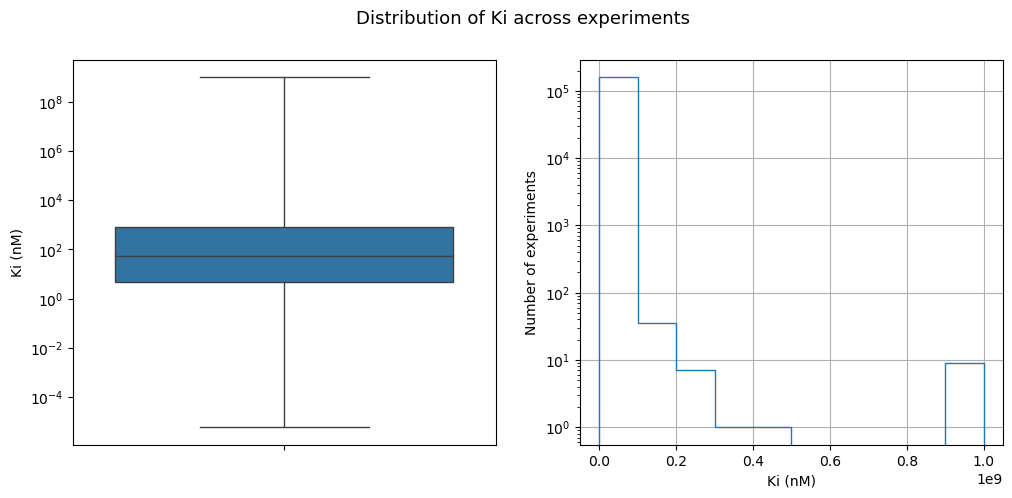

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(pd.to_numeric(binding_df['Ki (nM)'].dropna()), whis=np.inf, ax=axes[0])
axes[0].set_yscale('log')

pd.to_numeric(binding_df['Ki (nM)'].dropna()).hist(histtype='step', log=True, ax=axes[1])
axes[1].set_xlabel('Ki (nM)')
axes[1].set_ylabel('Number of experiments')

fig.suptitle('Distribution of Ki across experiments', fontsize=13);

**EC50**

Effective concentration: concentration of ligand that induces 50% of the target maximal biological effect ↬ potency of an agonist (vs. IC50: antagonist)

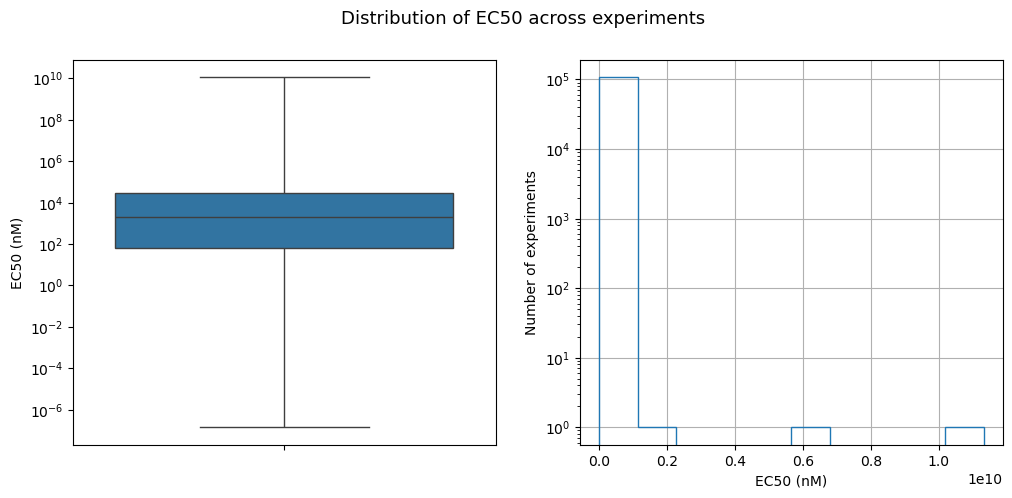

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(pd.to_numeric(binding_df['EC50 (nM)'].dropna()), whis=np.inf, ax=axes[0])
axes[0].set_yscale('log')

pd.to_numeric(binding_df['EC50 (nM)'].dropna()).hist(histtype='step', log=True, ax=axes[1])
axes[1].set_xlabel('EC50 (nM)')
axes[1].set_ylabel('Number of experiments')

fig.suptitle('Distribution of EC50 across experiments', fontsize=13);

**IC50**

Inhibitory concentration: concentration of ligand to reduce the activity of the target by 50% ↬ functional effect on target

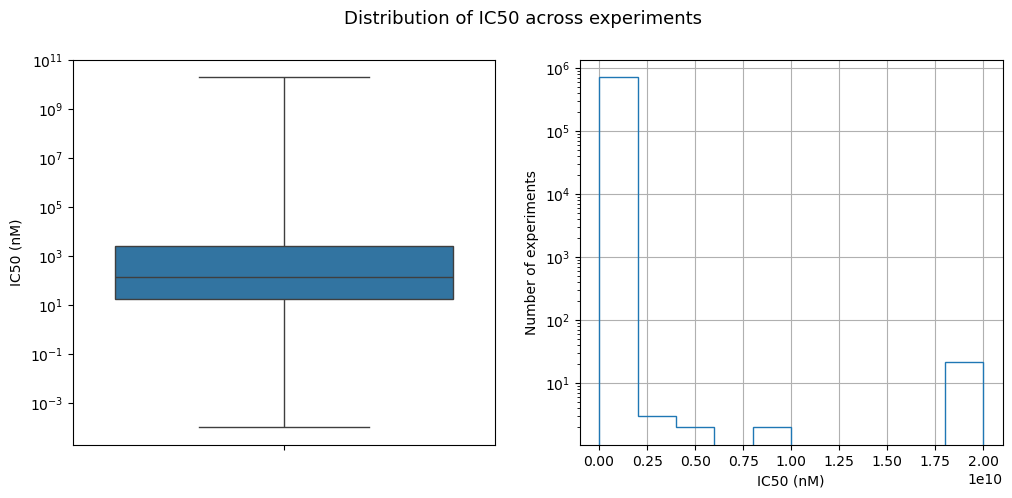

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(pd.to_numeric(binding_df['IC50 (nM)'].dropna()), whis=np.inf, ax=axes[0])
axes[0].set_yscale('log')

pd.to_numeric(binding_df['IC50 (nM)'].dropna()).hist(histtype='step', log=True, ax=axes[1])
axes[1].set_xlabel('IC50 (nM)')
axes[1].set_ylabel('Number of experiments')

fig.suptitle('Distribution of IC50 across experiments', fontsize=13);

#### **Multivariate analysis**

Visualize the relation between `Ki` and `IC50`: inner join on numerical values (excluding NaN).

In [17]:
joint_df_ki_ic50 = binding_df.loc[(~binding_df['IC50 (nM)'].isna()) & (~binding_df['Ki (nM)'].isna())]
print('{:.2f}% of the whole dataset remain after jointly removing all NaN entries from Ki and IC50 columns.'.format(joint_df_ki_ic50.shape[0]/binding_df.shape[0]*100))

0.32% of the whole dataset remain after jointly removing all NaN entries from Ki and IC50 columns.


Although the percentage of remaining values after droping all NaN in either `Ki` and `IC50` is very low, they are both related to target inhibition: `Ki` reflects the binding affinity, while `IC50` reflects the functional effect on the target (how much the ligand can reduce the target's activity).

Moreover, if there is a strong correlation between the 2 covariates, we could even think of interpolating missing data.

In [18]:
joint_df_ki_ic50['Ki (nM)'] = joint_df_ki_ic50['Ki (nM)'].astype(float)
joint_df_ki_ic50['IC50 (nM)'] = joint_df_ki_ic50['IC50 (nM)'].astype(float)

/tmp/ipykernel_3516/1094228352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_ki_ic50['Ki (nM)'] = joint_df_ki_ic50['Ki (nM)'].astype(float)
/tmp/ipykernel_3516/1094228352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_ki_ic50['IC50 (nM)'] = joint_df_ki_ic50['IC50 (nM)'].astype(float)


**Regression analysis**

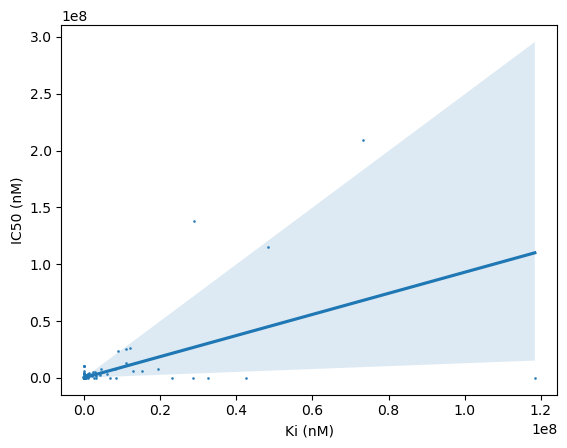

In [19]:
sns.regplot(data=joint_df_ki_ic50, x='Ki (nM)', y='IC50 (nM)', scatter_kws={'s':1});

Logarithmic scale

In [20]:
log_joint_df_ki_ic50 = joint_df_ki_ic50
log_joint_df_ki_ic50[['Ki (nM)', 'IC50 (nM)']] = joint_df_ki_ic50[['Ki (nM)', 'IC50 (nM)']].apply(np.log)

/tmp/ipykernel_3516/2241123252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_joint_df_ki_ic50[['Ki (nM)', 'IC50 (nM)']] = joint_df_ki_ic50[['Ki (nM)', 'IC50 (nM)']].apply(np.log)


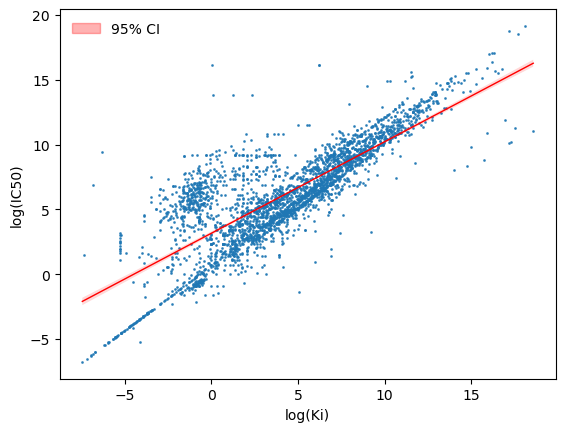

In [21]:
sns.regplot(x=log_joint_df_ki_ic50['Ki (nM)'], y=log_joint_df_ki_ic50['IC50 (nM)'], ci=95, scatter_kws={'s':1}, line_kws={'color':'r', 'linewidth':1})
plt.xlabel('log(Ki)')
plt.ylabel('log(IC50)')
ci_patch = mpatches.Patch(color='red', alpha=0.3, label='95% CI')
plt.legend(handles=[ci_patch], loc='upper left', frameon=False);

In [22]:
mod = smf.ols(formula='Q("IC50 (nM)") ~ Q("Ki (nM)")', data=log_joint_df_ki_ic50)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("IC50 (nM)")   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     6044.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:26:49   Log-Likelihood:                -6996.6
No. Observations:                3175   AIC:                         1.400e+04
Df Residuals:                    3173   BIC:                         1.401e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1653      0.055     58.068   

**Non-parametric correlation analysis**

Indeed, although the effect size ($\sqrt{R^2}$) is large, it is yet to be verified that the assumptions of the parametric hypothesis test used in regression analysis are met (i.i.d. variables, conditional Gaussian distribution).

For now, let us use the *non-parametric* Spearman's correlation.

In [23]:
r, p = stats.spearmanr(log_joint_df_ki_ic50['IC50 (nM)'], log_joint_df_ki_ic50['Ki (nM)'])
print('{r2:.3f} (R^2) is the proportion of variability in log(IC50) that can be explained by the variability in log(Ki) (and reciprocally). \nThe Spearman correlation is of {r:.3f}.'.format(r2=r**2, r=r))

0.624 (R^2) is the proportion of variability in log(IC50) that can be explained by the variability in log(Ki) (and reciprocally). 
The Spearman correlation is of 0.790.


#### **First draft of dimensionality reduction**

Let's perform a PCA and identify which characteristics lead to the clustering among ligands: study the *weight* of each variable in the PCA.

First, we need to retrieve the experiments that gathered all the covariates of interest: we already know that we will lose a lot of data this way, but it can help us identify relevant covariates. Yet, for instance, it does not make sense to study `IC50` jointly to `EC50`, since both characterize opposite chemical processes.

In [24]:
binding_df_without_nan = binding_df.loc[(~binding_df['IC50 (nM)'].isna()) & (~binding_df['Ki (nM)'].isna()) & (~binding_df['kon (M-1-s-1)'].isna()) & (~binding_df['koff (s-1)'].isna())]

In [25]:
binding_df_without_nan.shape[0] 

0

In [26]:
binding_df.loc[(~binding_df['kon (M-1-s-1)'].isna()) & (~binding_df['koff (s-1)'].isna())].shape[0]

38

Actually there are only 38 entries in the dataset that provide information about both `kon` and `koff`. If we only use 2 covariates, it no longer makes sense to apply dimensionality reduction.

Still, we are left with the experimental conditions, and we could still visualize whether there exist a protein clustering in the `Ki`-`IC50` space.

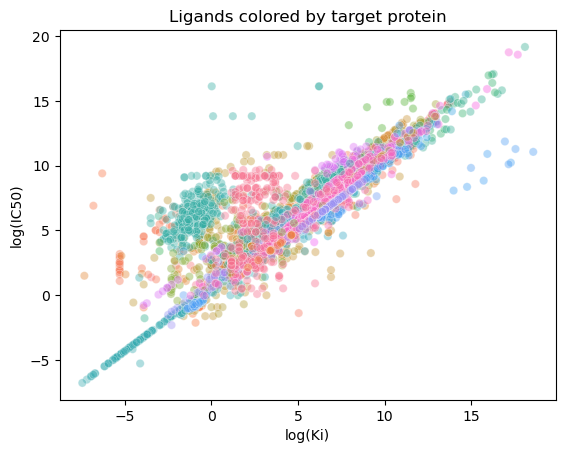

In [27]:
sns.scatterplot(data=log_joint_df_ki_ic50, x='Ki (nM)', y='IC50 (nM)', hue='Target Name', legend=False, alpha=0.4)
plt.xlabel('log(Ki)')
plt.ylabel('log(IC50)')
plt.title('Ligands colored by target protein');

The upper graph is useless. 

- It would be neat to be able to visualize each protein by selecting it on a control panel (interactive plot). 
- Instead of using random colors, we could also color each dot by the dissimilarity of the target sequence to a reference sequence. As mentioned, can be expensive, but disregarding this aspect, we could easily see how sequence similarity impacts `Ki` and `IC50`, or alternatively, we could do it only for protein isoforms and mutated versions.

**How many experiments per ligand?**

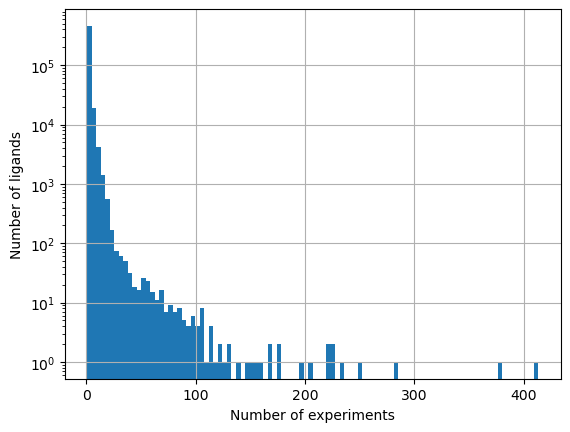

In [26]:
binding_df['BindingDB Ligand Name'].value_counts().hist(bins=100, log=True)
plt.xlabel('Number of experiments')
plt.ylabel('Number of ligands');

It would be interesting to look at the range of proteins studied against a unique ligand: should we measure sequence similarity?

In [43]:
exp_per_ligand = binding_df['BindingDB Ligand Name'].value_counts()
binding_df[binding_df['BindingDB Ligand Name']==exp_per_ligand.keys()[0]]['Target Name'].value_counts()

Target Name
D(2) dopamine receptor                       76
5-hydroxytryptamine receptor 7               25
5-hydroxytryptamine receptor 2A              24
5-hydroxytryptamine receptor 2C              22
D(3) dopamine receptor                       22
                                             ..
Adenosine receptor A2a                        1
Glycine amidinotransferase, mitochondrial     1
Glutamate receptor ionotropic, kainate 1      1
Nischarin                                     1
Glycine receptor subunit alpha-1              1
Name: count, Length: 64, dtype: int64

**How many different proteins per ligand?**

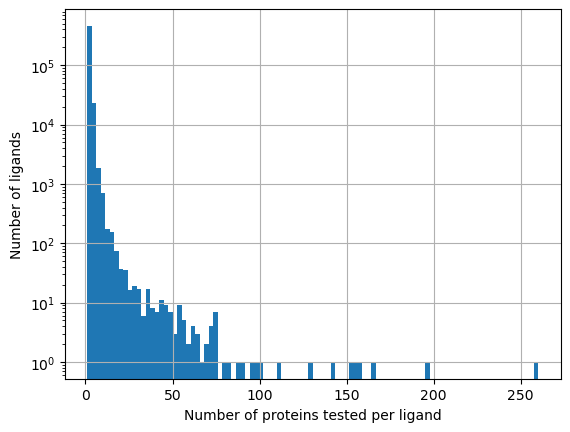

In [100]:
prot_per_lig.hist(bins=100, log=True)
plt.xlabel('Number of proteins tested per ligand')
plt.ylabel('Number of ligands')
plt.title('');

Reciprocally, it would be interesting to look at the range of ligands studied against a unique target, its isoforms and mutated versions. => Implies matching only on the first characters of the target name to exclude mutation or isoform specification.

In [29]:
binding_df['Target Name'].value_counts()

Target Name
Tyrosine-protein kinase BTK          13712
Tyrosine-protein kinase JAK2         13335
Orexin/Hypocretin receptor type 1    11249
P2X purinoceptor 7                   10893
Nuclear receptor ROR-gamma           10209
                                     ...  
Dipeptidyl peptidase 9 [E286A]           1
Dipeptidyl peptidase 9 [I288A]           1
Dipeptidyl peptidase 9 [H289A]           1
Dipeptidyl peptidase 9 [V290A]           1
Dipeptidyl peptidase 9 [S292A]           1
Name: count, Length: 3578, dtype: int64

In [50]:
binding_df_ignore_mutations = binding_df
binding_df_ignore_mutations['Target Name'] = binding_df_ignore_mutations['Target Name'].str.replace(r"\[.*?\]", "", regex=True)

In [51]:
ligand_per_prot = binding_df_ignore_mutations['Target Name'].value_counts()
binding_df_ignore_mutations[binding_df_ignore_mutations['Target Name']==ligand_per_prot.keys()[0]]['BindingDB Ligand Name'].value_counts()

BindingDB Ligand Name
BDBM305696::US10144734, Example 713::US10172845, Example 714::US10441581, Example 714::US10881652, Example 714::US11648243, Example 714                   18
US10112942, Example 549::US10137124, Example 549::US10172851, Example 549::US10555944, Example 554::US10953005, Example 554                               17
US10112942, Example 550::US10137124, Example 550::US10172851, Example 550::US10555944, Example 555::US10953005, Example 555                               17
US10112942, Example 252::US10137124, Example 252::US10172851, Example 252::US10555944, Example 252::US10953005, Example 252                               14
US10112942, Example 543::US10112942, Example 546::US10137124, Example 543::US10172851, Example 543::US10555944, Example 543::US10953005, Example 543      14
                                                                                                                                                          ..
2-(4-Amino-1-cyclohexyl-1H-pyrazolo[